# Test SPICE propagator developed

2019/11/07
Development notebook is SPICE_propagator_develop

Developed function is spicegator.py

In [1]:
import spiceypy as spice
import pandas as pd
import spicegator as sg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
# load spice kernels
spice.furnsh('../spice/naif0012.tls')

# define gravitational parameters
MU = 1.32712440018*10**11      # sun's gravitational parameter [km^3/s^2]
au2km = 1.49597870691*10**8    # 1 astronomical unit [AU] to [km]
g0 = 9.80665                   # gravitational acceleration [m/s^2]

In [3]:
# import ephemerides data from GTOC4 into pandas dataframe
elmnts = ['Name','Epoch','a','e','i','LAN','periap','theta']
df = pd.read_fwf('../gtoc4_problem_data.txt', sep='\t', skiprows=1)

# reassign column names
df.columns =  ['Name','Epoch','a','e','i','LAN','omega','M0']

# convert 'Name' from 'xxxx' to xxxx integers
num,tmp = df.shape
for i in range(num):
    dmp = df.at[i,'Name']
    df.at[i,'Name'] = int(dmp[1:5])
    
print(df.shape)
df.head(10)

# create smaller pandas dataframe to test propagator
# FIXME : create here spacecraft dataframe, then merge?
#  df1.merge(df2, left_on='lkey', right_on='rkey')
el_pd1 = df[0:10]
el_pd1.shape

(1436, 8)


(1000, 8)

In [4]:
# test run function with el_pd1
# propagation range time
etr_utc = ['Jan 1, 2015', 'Jan 1, 2025']  # currently working with 6 months ~ 182 days
etr_MJD = [spice.str2et(etr_utc[0]), spice.str2et(etr_utc[1])]
# set time-step in seconds
steps = 100
dt = (spice.str2et(etr_utc[1]) - spice.str2et(etr_utc[0]))/steps
dt_day = dt/(60*60*24)
print(f'Current time-interval size with {steps} steps : {dt_day:.4} [days]')

# call function to propagate
et, sv, dr, drnorm = sg.propagate_spice(etr_MJD, el_pd1, MU=1.32712440018*10**11, step=steps, sv_option=True, dr_option=True)



Current time-interval size with 100 steps : 36.53 [days]
Propagation time: 24.74 [sec]


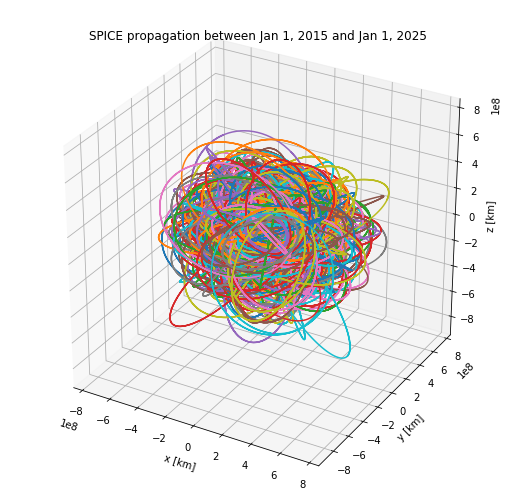

In [5]:
# plot propagated trajectories
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection = '3d')

# store number of bodies to propagate
[bdy,tmp] = el_pd1.shape
# store number of time steps
[tmp,steps,tmp] = sv.shape

# FIXME - ploting...? make a function?
for j in range(bdy):
    tmpx = []
    tmpy = []
    tmpz = []
    for i in range(steps):
        tmpx.append(sv[(j,i,0)])
        tmpy.append(sv[(j,i,1)])
        tmpz.append(sv[(j,i,2)])
    ax.plot(tmpx,tmpy,tmpz)

plt.title(f'SPICE propagation between {etr_utc[0]} and {etr_utc[1]}')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')
plt.show()

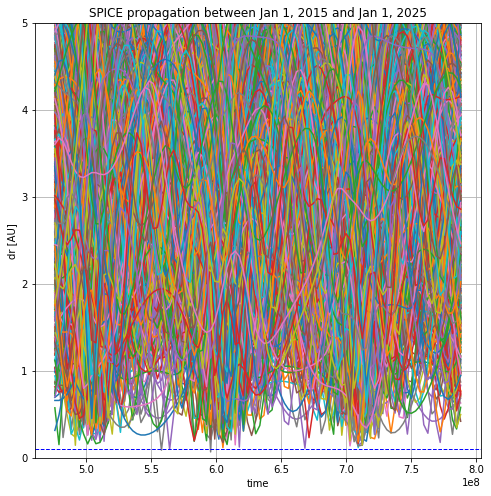

['2015-01-28T18:40:00', '2015-03-06T07:23:13', '2015-04-11T20:06:25', '2015-05-18T08:49:37', '2015-06-23T21:32:49', '2015-07-30T10:16:00', '2015-09-04T22:59:12', '2015-10-11T11:42:24', '2015-11-17T00:25:36', '2015-12-23T13:08:48', '2016-01-29T01:52:00', '2016-03-05T14:35:12', '2016-04-11T03:18:24', '2016-05-17T16:01:36', '2016-06-23T04:44:48', '2016-07-29T17:28:00', '2016-09-04T06:11:12', '2016-10-10T18:54:24', '2016-11-16T07:37:36', '2016-12-22T20:20:48', '2017-01-28T09:03:59', '2017-03-05T21:47:11', '2017-04-11T10:30:23', '2017-05-17T23:13:35', '2017-06-23T11:56:47', '2017-07-30T00:39:59', '2017-09-04T13:23:11', '2017-10-11T02:06:23', '2017-11-16T14:49:35', '2017-12-23T03:32:47', '2018-01-28T16:15:59', '2018-03-06T04:59:11', '2018-04-11T17:42:23', '2018-05-18T06:25:35', '2018-06-23T19:08:47', '2018-07-30T07:51:59', '2018-09-04T20:35:11', '2018-10-11T09:18:23', '2018-11-16T22:01:35', '2018-12-23T10:44:47', '2019-01-28T23:27:59', '2019-03-06T12:11:11', '2019-04-12T00:54:23', '2019-05-1

In [6]:
# plot computed relative distances of spacecraft to asteroids
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

# convert time-axis
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/et2utc_c.html
et_utc = []
for i in range(len(et)):
    et_utc.append(spice.et2utc(et[i],"ISOC",-3))
    
# number of objects propagated (without spacecraft)
for j in range(bdy-1):
    drlst = []
    for i in range(steps):
        drlst.append(drnorm[j,i,0]/au2km)
    ax.plot(et, drlst)
    
plt.title(f'SPICE propagation between {etr_utc[0]} and {etr_utc[1]}')

# plot threashold dr
plt.axhline(y=0.1, label='dr = 0.1 AU',ls='--',lw=1,c='b')

ax.set_xlabel('time')
ax.set_ylabel('dr [AU]')
plt.ylim(0, 5)
plt.grid()
plt.show()

print(et_utc)